## Gray-Wyner System Demo

Author: Cheuk Ting Li  
Based on El Gamal and Kim, _Network Information Theory_, Ch. 14

In [1]:
from psitip import *
PsiOpts.setting(solver = "pyomo.glpk")  # Set linear programming solver
PsiOpts.setting(repr_latex = True)      # Turn on Jupyter Notebook LaTeX display
PsiOpts.setting(venn_latex = True)      # Turn on LaTeX in diagrams

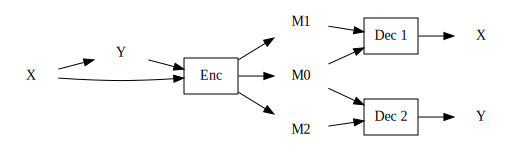

In [2]:
X, Y, U = rv("X, Y, U")
M0, M1, M2 = rv_array("M", 3)
R0, R1, R2 = real_array("R", 3)

model = CodingModel()         # Define Gray-Wyner system
model.set_rate(M0, R0)        # The rate of M0, M1, M2 are R0, R1, R2 resp.
model.set_rate(M1, R1)
model.set_rate(M2, R2)
model.add_edge(X, Y)          # X, Y are correlated source
model.add_node(X+Y, M0+M1+M2,
            label = "Enc")  # Encoder maps X,Y to M0,M1,M2
model.add_node(M0+M1, X,
            label = "Dec 1")  # Decoder 1 maps M0,M1 to X
model.add_node(M0+M2, Y,
            label = "Dec 2")  # Decoder 2 maps M0,M2 to Y

model.graph()                 # Draw diagram

In [3]:
r = model.get_inner()  # Automatic inner bound
r

( ( R1 >= 0 )
 &( R2 >= 0 )
 &( R0 >= 0 )
 &( R0+R2 >= H(Y)+I(A_M0&X|Y) )
 &( R0+R1 >= H(X)+I(A_M0&Y|X) )
 &( R0+R1+R2 >= H(X)+H(Y|A_M0)+I(A_M0&Y|X) ) ).exists(A_M0)

In [4]:
# Although the above region does not look like the Gray-Wyner region [Gray-Wyner 1974],
#  they are actually equivalent.

# Write the Gray-Wyner region
r_gw = ((R0 >= I(X+Y&U)) & (R1 >= H(X|U)) & (R2 >= H(Y|U))).exists(U)
r_gw

( ( R0 >= I(X+Y&U) )
 &( R1 >= H(X|U) )
 &( R2 >= H(Y|U) ) ).exists(U)

In [5]:
# Prove r is the same region as r_gw
r.equiv(r_gw, aux_hull = True)  # aux_hull option is needed to enable rate splitting

True

In [6]:
r_out = model.get_outer()              # Automatic outer bound
CompArray((r_out >> r).check_getaux()) # Converse proof, print auxiliary

CompArray(
[[A_M0, X_P+M0]])

### Extremal Points and Corner Points

In [7]:
# Minimum sum rate is H(X, Y)
sumrate = r.minimum(R0 + R1 + R2, [R0, R1, R2])
sumrate

H(Y+X)

In [8]:
# Minimum weighted sum rate when R0 is counted twice is H(X)+H(Y)
wsumrate = r.minimum(R0 * 2 + R1 + R2, [R0, R1, R2])
wsumrate

H(Y)+H(X)

In [9]:
# Minimum symmetric rate
symrate = r.minimum(emax(R0, R1, R2), [R0, R1, R2])
symrate

(( universe() ).exists(A_M0)).minimum(emax((1/2)*H(X)+(1/2)*I(A_M0&Y|X), (1/2)*H(Y)+(1/2)*I(A_M0&X|Y), (1/3)*H(X)+(1/3)*H(Y|A_M0)+(1/3)*I(A_M0&Y|X)))

In [10]:
# The corner point max R0 s.t. R0 + R1 = H(X), R0 + R2 = H(Y)
corner1 = (r & (R0 + R1 == H(X)) & (R0 + R2 == H(Y))).maximum(R0, [R0, R1, R2])
corner1

(( ( markov(A_M0, X, Y) )
 &( markov(A_M0, Y, X) ) ).exists(A_M0)).maximum(I(Y&A_M0))

In [11]:
# Trying to prove that corner1 = Gacs-Korner common information [Gacs-Korner 1973]
print(bool(corner1 <= gacs_korner(X & Y)))  # This fails
print(bool(corner1 >= gacs_korner(X & Y)))  # This is correct

False
True


In [12]:
# To prove corner1 = Gacs-Korner CI, we need the double Markov property
with dblmarkov().assumed():
    print(bool(corner1 <= gacs_korner(X & Y)))
    print(bool(corner1 >= gacs_korner(X & Y)))

True
True


In [13]:
# The corner point min R0 s.t. R0 + R1 + R2 = H(X,Y)
corner2 = (r & (R0 + R1 + R2 == H(X+Y))).minimum(R0, [R0, R1, R2])
corner2

(( ( markov(Y, A_M0, X) ) ).exists(A_M0)).minimum(I(Y+X&A_M0))

In [14]:
# This is clearly Wyner's common information [Wyner 1975]
bool(corner2 == wyner_ci(X & Y))

True

In [15]:
# The corner point min R0 s.t. R0 + R2 = H(Y), R1 = H(X|Y)
corner3 = (r & (R0 + R2 == H(Y)) & (R1 == H(X|Y))).minimum(R0, [R0, R1, R2])
corner3

(( ( markov(X, Y, A_M0) )
 &( markov(X, A_M0, Y) ) ).exists(A_M0)).minimum(I(Y&A_M0))

In [16]:
# This is the necessary conditional entropy [Cuff-Permuter-Cover 2010] plus I(X;Y)
with dblmarkov().assumed():
    print(bool(corner3 <= H_nec(Y | X) + I(X & Y)))
    print(bool(corner3 >= H_nec(Y | X) + I(X & Y)))

True
True


### References
- R. M. Gray and A. D. Wyner, "Source coding for a simple network," Bell Syst. Tech. J., vol. 53, no. 9, pp. 1681–1721, 1974.
- P. Gács and J. Körner, "Common information is far less than mutual information," Problems Control Inf. Theory, vol. 2, no. 2, pp. 149–162, 1973.
- A. D. Wyner, "The common information of two dependent random variables," IEEE Trans. Inf. Theory, vol. IT-21, no. 2, pp. 163–179, Mar. 1975.
- P. W. Cuff, H. H. Permuter, and T. M. Cover, "Coordination capacity," IEEE Trans. Inf. Theory, vol. 56, no. 9, pp. 4181–4206, Sep. 2010.
- C. T. Li and A. El Gamal, "Extended Gray–Wyner system with complementary causal side information," IEEE Trans. Inf. Theory, vol. 64, no. 8, pp. 5862–5878, 2017
